# Setup + downloading data



In [1]:
import os
import pandas as pd
from qiime2 import Visualization
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
data_dir = "project_data"
os.makedirs(data_dir, exist_ok=True)
data_dir

'project_data'

In [3]:
%%bash -s "$data_dir"
set -e
mkdir -p "$1"
cd "$1"

if [ ! -f ITS1_sequences.qza ]; then
    echo "Downloading ITS1_sequences.qza …"
    wget -q -O ITS1_sequences.qza \
        "https://polybox.ethz.ch/index.php/s/uV06vmm96ZzB5eM/download"
else
    echo "ITS1_sequences.qza already exists – skipping download."
fi

if [ ! -f sample_metadata.tsv ]; then
    echo "Downloading sample_metadata.tsv …"
    wget -q -O sample_metadata.tsv \
        "https://polybox.ethz.ch/index.php/s/CA76kKFC9FApqpR/download"
else
    echo "sample_metadata.tsv already exists – skipping download."
fi

ls -lh

ITS1_sequences.qza already exists – skipping download.
sample_metadata.tsv already exists – skipping download.
total 683M
-rw-r--r-- 1 jovyan jovyan 680M Oct  2 12:07 ITS1_sequences.qza
-rw-r--r-- 1 jovyan jovyan  83K Oct  2 12:16 dada2_rep_set.qza
-rw-r--r-- 1 jovyan jovyan 325K Oct  2 12:17 dada2_rep_set.qzv
-rw-r--r-- 1 jovyan jovyan  54K Oct  2 12:16 dada2_stats.qza
-rw-r--r-- 1 jovyan jovyan 1.3M Oct  2 12:16 dada2_stats.qzv
-rw-r--r-- 1 jovyan jovyan  92K Oct  2 12:16 dada2_table.qza
-rw-r--r-- 1 jovyan jovyan 486K Oct  2 12:17 dada2_table.qzv
-rw-r--r-- 1 jovyan jovyan 333K Oct  2 12:09 demux_seqs.qzv
-rw-r--r-- 1 jovyan jovyan  19K Oct  2 12:07 sample_metadata.tsv


# Meta data analysis

In [4]:
metadata_df = pd.read_csv(f'{data_dir}/sample_metadata.tsv', sep='\t', index_col=0)
metadata_df.sample(5)

,country_sample,state_sample,latitude_sample,longitude_sample,sex_sample,age_years_sample,height_cm_sample,weight_kg_sample,bmi_sample,diet_type_sample,ibd_sample,gluten_sample
ID,,,,,,,,,,,,
ERR5327308,Australia,NSW,-33.7,151.2,male,36.0,186.0,85.0,24.57,Omnivore,Self-diagnosed,No
ERR5327285,Sweden,Stockholms län,59.3,18.0,male,27.0,180.0,62.0,19.14,Omnivore,I do not have this condition,No
ERR5327586,United Kingdom,Not provided,53.9,-1.6,female,75.0,157.0,57.0,23.05,Vegetarian but eat seafood,I do not have this condition,No
ERR5327363,Australia,QLD,-27.5,153.1,female,54.0,165.0,68.0,24.98,Omnivore,I do not have this condition,No
ERR5327506,United Kingdom,Not provided,52.0,-2.1,male,55.0,193.0,94.0,25.32,Omnivore,Not provided,Not provided


In [5]:
metadata_df.describe()

,country_sample,state_sample,latitude_sample,longitude_sample,sex_sample,age_years_sample,height_cm_sample,weight_kg_sample,bmi_sample,diet_type_sample,ibd_sample,gluten_sample
count,150,150,150,150,150,150,150,150,150,150,150,150
unique,8,30,86,81,4,64,47,70,135,6,4,5
top,United Kingdom,Not provided,51.5,145.0,male,55.0,180.0,63.0,Not provided,Omnivore,I do not have this condition,No
freq,54,58,14,5,79,6,15,8,3,118,130,113


<Axes: title={'center': 'Sex ratio'}, xlabel='sex_sample'>

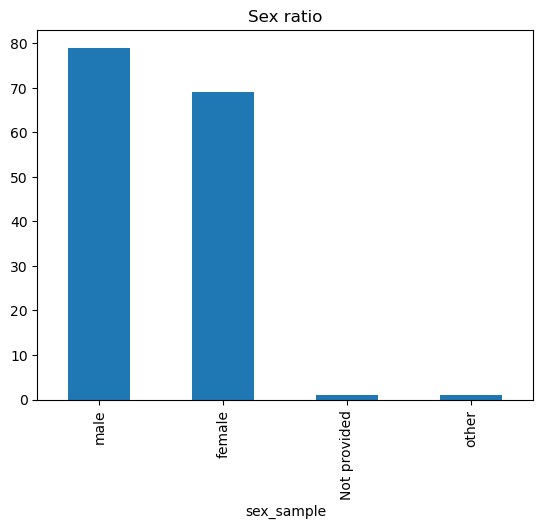

In [6]:
metadata_df['sex_sample'].value_counts().plot(kind='bar', title='Sex ratio')

In [7]:
# coerce several columns to numeric
num_cols = ['age_years_sample','height_cm_sample','weight_kg_sample',
            'bmi_sample','latitude_sample','longitude_sample']
metadata_df[num_cols] = (metadata_df[num_cols]
                         .replace('Not provided', pd.NA)
                         .apply(pd.to_numeric, errors='coerce'))

In [8]:
(mean_bmi_by_country :=
    metadata_df.groupby('country_sample')['bmi_sample']
               .mean()
               .sort_values(ascending=False))

mean_bmi_by_country

country_sample
Not provided      28.110000
USA               24.672500
United Kingdom    24.519444
New Zealand       24.363333
Australia         23.197619
Germany           22.630000
Isle of Man       21.970000
Sweden            19.140000
Name: bmi_sample, dtype: float64

# Sequence import & summary

In [9]:
seqs_qza = f'{data_dir}/ITS1_sequences.qza'

In [10]:
!qiime tools peek {seqs_qza}

UUID:        3638611d-1767-413b-9390-70ee3d78e4ff
Type:        SampleData[SequencesWithQuality]
Data format: SingleLanePerSampleSingleEndFastqDirFmt


In [11]:
!qiime demux summarize \
  --i-data {seqs_qza} \
  --o-visualization {data_dir}/demux_seqs.qzv

Visualization.load(f"{data_dir}/demux_seqs.qzv")

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: project_data/demux_seqs.qzv


<visualization: Visualization uuid: 24194e71-164b-4013-9412-b390aed10234>

# Feature table construction

In [12]:
! qiime dada2 denoise-single \
  --i-demultiplexed-seqs project_data/ITS1_sequences.qza \
  --p-trunc-len 130 \
  --p-n-threads 3 \
  --o-table project_data/dada2_table.qza \
  --o-representative-sequences project_data/dada2_rep_set.qza \
  --o-denoising-stats project_data/dada2_stats.qza

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved FeatureTable[Frequency] to: project_data/dada2_table.qza
Saved FeatureData[Sequence] to: project_data/dada2_rep_set.qza
Saved SampleData[DADA2Stats] to: project_data/dada2_stats.qza


### Denoising - Amplicon Sequence Variants

In [13]:
! qiime metadata tabulate \
  --m-input-file project_data/dada2_stats.qza \
  --o-visualization project_data/dada2_stats.qzv

! qiime feature-table tabulate-seqs \
  --i-data project_data/dada2_rep_set.qza \
  --o-visualization project_data/dada2_rep_set.qzv

! qiime feature-table summarize \
  --i-table project_data/dada2_table.qza \
  --m-sample-metadata-file project_data/sample_metadata.tsv \
  --o-visualization project_data/dada2_table.qzv

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: project_data/dada2_stats.qzv
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Saved Visualization to: project_data/dada2_rep_set.qzv
/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 

In [14]:
Visualization.load("project_data/dada2_table.qzv")

<visualization: Visualization uuid: a9a1c80d-5114-4ae0-aff1-aa4740b588bf>

In [15]:
Visualization.load("project_data/dada2_stats.qzv")

<visualization: Visualization uuid: db839dcc-326e-46c4-aa55-1e1d19063372>